In [3]:
import geopandas as gpd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
# === 读取重命名后的数据 ===
gdf = gpd.read_file("cyb_shenzhen.geojson")
gdf

,C_Direction,C_length,C_lanes,C_free_speed,C_capacity,C_link_type,L_poi_entropy300,L_poi_entropy200,L_poi_entropy100,L_urban_mean,...,new_id,CY_W_pop,CY_A_pop,CY_H_pop,CY_Spend,CY_A_0_14,CY_A_15_64,CY_A__65,CY_A_un,geometry
0,1.0,84.35005,2.0,60.0,1600.0,4.0,2.344328,2.275494,2.095245,0.555398,...,1,27036.000000,109750.000000,35350.000000,98775.000000,0.000000,42152.000000,982.000000,19250.000000,"LINESTRING (202539.815 2495642.37, 202545.557 ..."
1,1.0,97.89807,2.0,60.0,1600.0,4.0,2.333363,2.358557,2.042457,0.556768,...,2,27036.000000,109750.000000,35350.000000,98775.000000,0.000000,42152.000000,982.000000,19250.000000,"LINESTRING (202442.527 2495631.464, 202451.359..."
2,1.0,202.35069,1.0,30.0,1000.0,6.0,2.340610,2.349755,2.230589,0.556712,...,3,27036.000000,109750.000000,35350.000000,98775.000000,0.000000,42152.000000,982.000000,19250.000000,"LINESTRING (202539.815 2495642.37, 202536.814 ..."
3,1.0,90.16309,2.0,60.0,1600.0,4.0,2.284729,2.269102,2.032923,0.515611,...,4,27036.000000,109750.000000,35350.000000,98775.000000,0.000000,42152.000000,982.000000,19250.000000,"LINESTRING (202623.506 2495652.874, 202645.168..."
4,0.0,181.39623,1.0,30.0,1000.0,6.0,2.346104,2.271958,2.226527,0.544429,...,5,27036.000000,109750.000000,35350.000000,98775.000000,0.000000,42152.000000,982.000000,19250.000000,"LINESTRING (202621.611 2495471.496, 202623.017..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115360,1.0,65.61365,1.0,5.0,800.0,10.0,1.277034,0.562335,-0.000000,0.600000,...,146327,39.000000,372.000000,177.000000,3325.000000,0.000000,185.000000,4.000000,28.000000,"LINESTRING (185979.88 2509977.282, 185980.178 ..."
115361,1.0,179.19024,1.0,5.0,800.0,10.0,2.160589,1.771291,0.636514,0.291667,...,146329,8849.705773,26506.658585,31644.550522,489820.372394,2.197065,32192.053681,201.215967,8099.338848,"LINESTRING (194402.199 2511234.928, 194390.841..."
115362,1.0,137.13006,1.0,5.0,800.0,10.0,2.011048,1.945606,0.636514,0.562069,...,146330,2736.000000,6664.000000,4029.000000,51975.000000,4.000000,3944.000000,182.000000,2635.000000,"LINESTRING (190738.748 2495177.519, 190732.31 ..."
115363,1.0,138.57457,1.0,5.0,800.0,10.0,2.120728,1.977796,1.359237,0.562069,...,146331,2736.000000,6664.000000,4029.000000,51975.000000,4.000000,3944.000000,182.000000,2635.000000,"LINESTRING (190744.483 2495113.512, 190740.252..."


D:\Anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ 模型性能：R² = 0.7039, RMSE = 0.0451


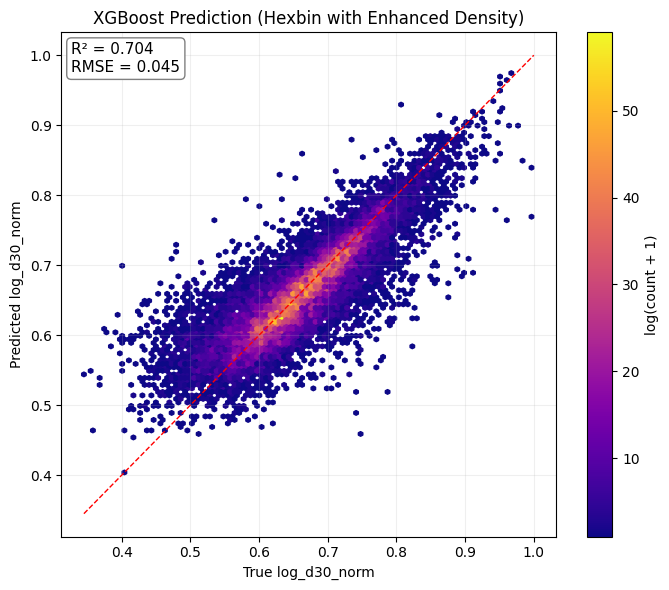

In [1]:
import geopandas as gpd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
import pandas as pd

# === 读取数据 ===
gdf = gpd.read_file("cyb_shenzhen.geojson")

# === 筛选非零目标值 & 合法出行方式
gdf_filtered = gdf[(gdf['log_d30_norm'] != 0) & (gdf['allow_uses_label'] != 0)]

# === 对 CY_ 开头的变量进行 log1p 和标准化 ===
cyb_cols = [col for col in gdf_filtered.columns if col.startswith('CY_')]
gdf_cyb = gdf_filtered[cyb_cols].apply(lambda x: np.log1p(x))  # log1p
scaler = StandardScaler()
gdf_cyb_scaled = pd.DataFrame(scaler.fit_transform(gdf_cyb), columns=cyb_cols, index=gdf_filtered.index)
gdf_filtered.update(gdf_cyb_scaled)

# === 特征选择：排除目标列、空间列、部分非输入列 & 所有 L_ 开头列 ===
exclude_cols = [
    'log_d10_norm', 'log_d20_norm', 'log_d30_norm',  'poi_entropy100', 'poi_entropy200',
    'geometry', 'new_id','clo','deg_C','betw1000K','allow_uses_label',
    'L_filtered_weibo_count','C_length','L_poi_entropy200','L_poi_entropy100'
]
exclude_cols += [col for col in gdf_filtered.columns if col.startswith('L_')]

feature_cols = [col for col in gdf_filtered.columns if col not in exclude_cols]

# === 设置 X 和 y ===
X = gdf_filtered[feature_cols]
y = gdf_filtered['log_d30_norm']

# === 划分训练测试集 ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 模型训练 ===
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=8, random_state=42)
model.fit(X_train, y_train)

# === 预测与评估 ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"✅ 模型性能：R² = {r2:.4f}, RMSE = {rmse:.4f}")

# === Hexbin 可视化 ===
plt.figure(figsize=(7, 6))
hb = plt.hexbin(
    y_test, y_pred,
    gridsize=100,
    cmap='plasma',
    reduce_C_function=np.log1p,
    mincnt=1
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1)
plt.text(
    0.02, 0.98,
    f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    horizontalalignment='left',
    fontsize=11,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)
plt.xlabel("True log_d30_norm")
plt.ylabel("Predicted log_d30_norm")
plt.title("XGBoost Prediction (Hexbin with Enhanced Density)")
plt.colorbar(hb, label='log(count + 1)')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_31828\3871780206.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


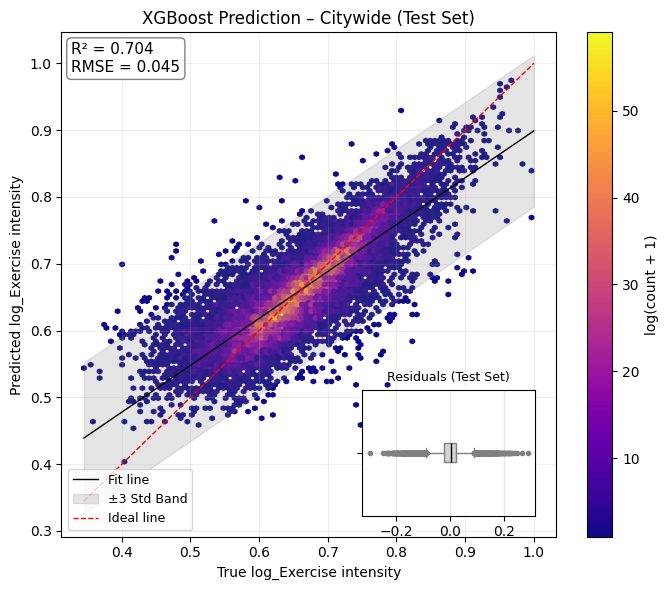

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# === 主图：测试集预测 Hexbin ===
fig, ax = plt.subplots(figsize=(7, 6))

hb = ax.hexbin(
    y_test, y_pred,
    gridsize=100,
    cmap='plasma',
    reduce_C_function=np.log1p,
    mincnt=1
)

# === 拟合线 + 置信区间 ===
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
x_line = np.linspace(y_test.min(), y_test.max(), 200)
y_fit = p(x_line)
fit_residuals = y_pred - p(y_test)
std = np.std(fit_residuals)
y_upper = y_fit + 3 * std
y_lower = y_fit - 3 * std

ax.plot(x_line, y_fit, "k-", lw=1, label="Fit line")
ax.fill_between(x_line, y_lower, y_upper, color='gray', alpha=0.2, label="±3 Std Band")
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1, label="Ideal line")

# === R² 和 RMSE 标注 ===
ax.text(
    0.02, 0.98,
    f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=ax.transAxes,
    verticalalignment='top',
    horizontalalignment='left',
    fontsize=11,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# === 主图设置 ===
ax.set_xlabel("True log_Exercise intensity")
ax.set_ylabel("Predicted log_Exercise intensity")
ax.set_title("XGBoost Prediction – Citywide (Test Set)")
ax.grid(alpha=0.2)
plt.colorbar(hb, ax=ax, label='log(count + 1)')

# === 子图：残差箱型图，位置上移 ===
residuals = y_test - y_pred
inset_ax = inset_axes(ax, width="35%", height="25%", loc='lower right', borderpad=1.5)

inset_ax.boxplot(residuals, vert=False, patch_artist=True,
                 boxprops=dict(facecolor='lightgray', color='gray'),
                 medianprops=dict(color='black'),
                 whiskerprops=dict(color='gray'),
                 capprops=dict(color='gray'),
                 flierprops=dict(marker='o', markersize=3, markerfacecolor='gray', markeredgecolor='gray'))

inset_ax.set_title("Residuals (Test Set)", fontsize=9)
inset_ax.tick_params(axis='y', labelleft=False)
inset_ax.grid(alpha=0.3)

# === 图例移动到左下角，避免遮挡文字 ===
ax.legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.savefig("保存结果用/cyb制图/全局散点.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()


In [3]:
print("📋 当前模型输入特征字段（共 {} 个）：".format(X.shape[1]))
for col in X.columns:
    print(f"- {col}")

📋 当前模型输入特征字段（共 43 个）：
- C_Direction
- C_lanes
- C_free_speed
- C_capacity
- C_link_type
- C_D_transport
- C_D_tree
- C_D_grass
- C_D_farmland
- C_D_building
- C_D_sparseveg
- C_D_water
- C_800_deg_C
- C_betw_800m
- C_clo_800m
- C_depth_800m
- P_road
- P_sidewalk
- P_building
- P_wall
- P_fence
- P_pole
- P_traffic li
- P_traffic si
- P_vegetation
- P_terrain
- P_sky
- P_person
- P_rider
- P_car
- P_truck
- P_bus
- P_train
- P_motorcycle
- P_bicycle
- CY_W_pop
- CY_A_pop
- CY_H_pop
- CY_Spend
- CY_A_0_14
- CY_A_15_64
- CY_A__65
- CY_A_un


⚙️ 正在计算全体 SHAP 值...


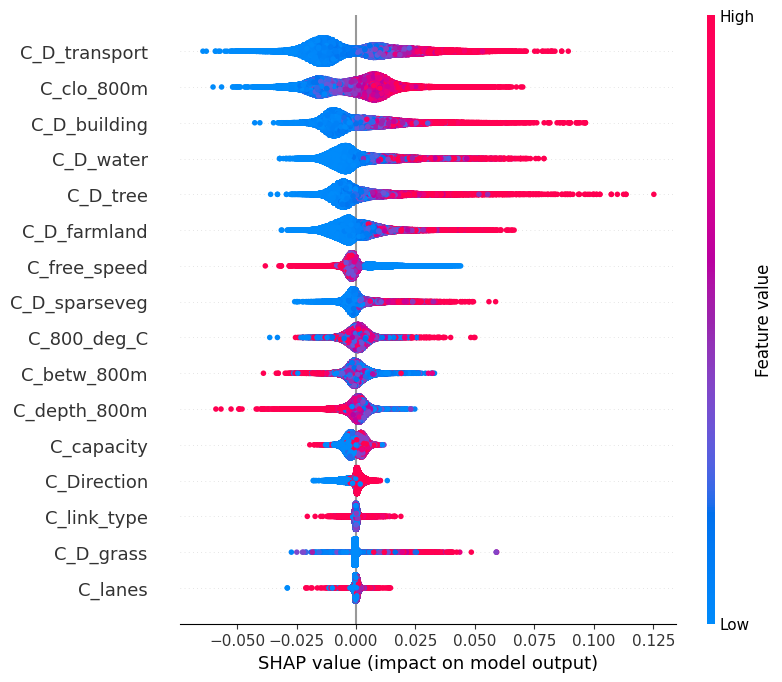

💾 已保存 C类变量 SHAP 值至: 保存结果用/cyb制图/shap_C.csv


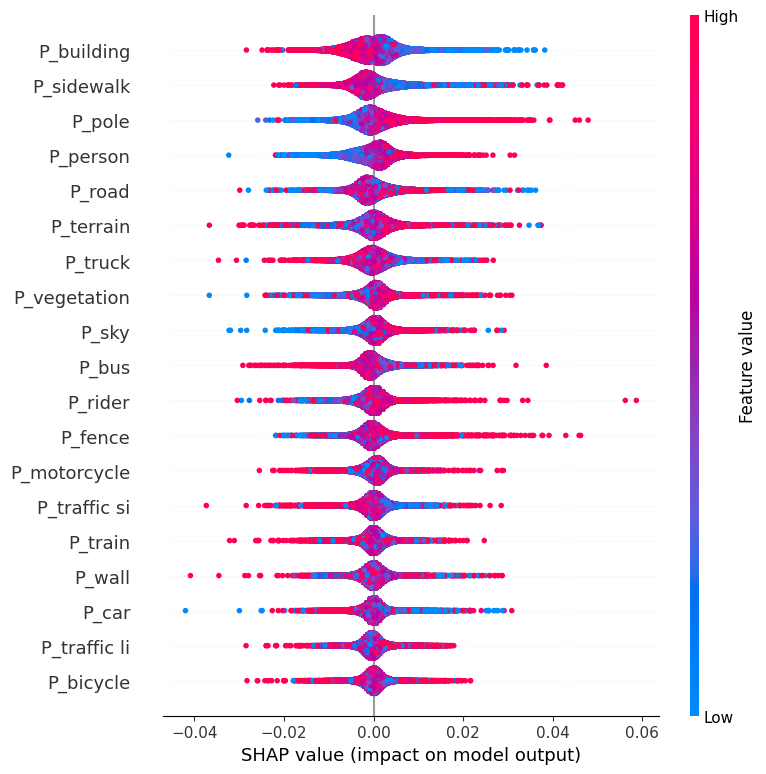

💾 已保存 P类变量 SHAP 值至: 保存结果用/cyb制图/shap_P.csv


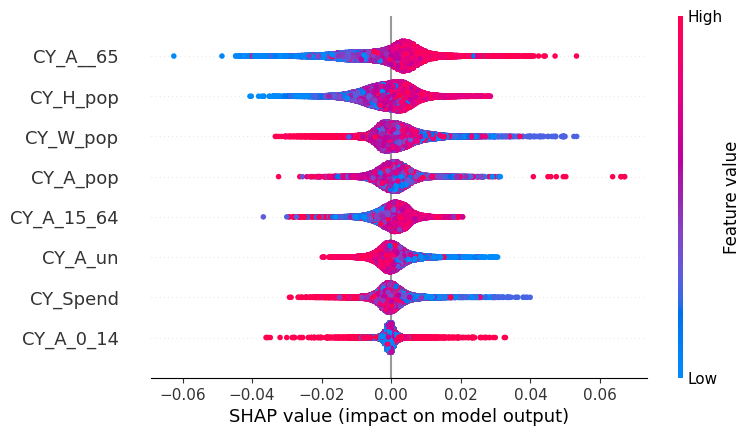

💾 已保存 L类变量 SHAP 值至: 保存结果用/cyb制图/shap_L.csv


In [4]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 使用 TreeExplainer 构造器（不使用简化版的 masker 变体）
explainer = shap.Explainer(model)

# 计算全体 SHAP 值
print("⚙️ 正在计算全体 SHAP 值...")
shap_values = explainer(X)

# 保存所有 SHAP 值（可选）
shap_df_all = pd.DataFrame(shap_values.values, columns=X.columns)
shap_df_all['new_id'] = gdf_filtered.loc[X.index, 'new_id'].values
shap_df_all.to_csv("保存结果用/cyb制图/shap_all.csv", index=False)

# 🎯 绘制某一类变量 SHAP 图（如 C_）
def plot_shap_by_prefix(prefix, name, save_path=None):
    cols = [col for col in X.columns if col.startswith(prefix)]
    if not cols:
        print(f"⚠️ 未找到前缀为 {prefix} 的列。")
        return
    shap_subset = shap_values[:, [X.columns.get_loc(col) for col in cols]]
    shap.plots.beeswarm(shap_subset, show=True, max_display=len(cols))
    if save_path:
        df_to_save = pd.DataFrame(shap_subset.values, columns=cols)
        df_to_save['new_id'] = gdf_filtered.loc[X.index, 'new_id'].values
        df_to_save.to_csv(save_path, index=False)
        print(f"💾 已保存 {name} SHAP 值至: {save_path}")


# ✅ 分别绘制 C/P/L 三组
plot_shap_by_prefix("C_", "C类变量", save_path="保存结果用/cyb制图/shap_C.csv")
plot_shap_by_prefix("P_", "P类变量", save_path="保存结果用/cyb制图/shap_P.csv")
plot_shap_by_prefix("CY_", "L类变量", save_path="保存结果用/cyb制图/shap_L.csv")

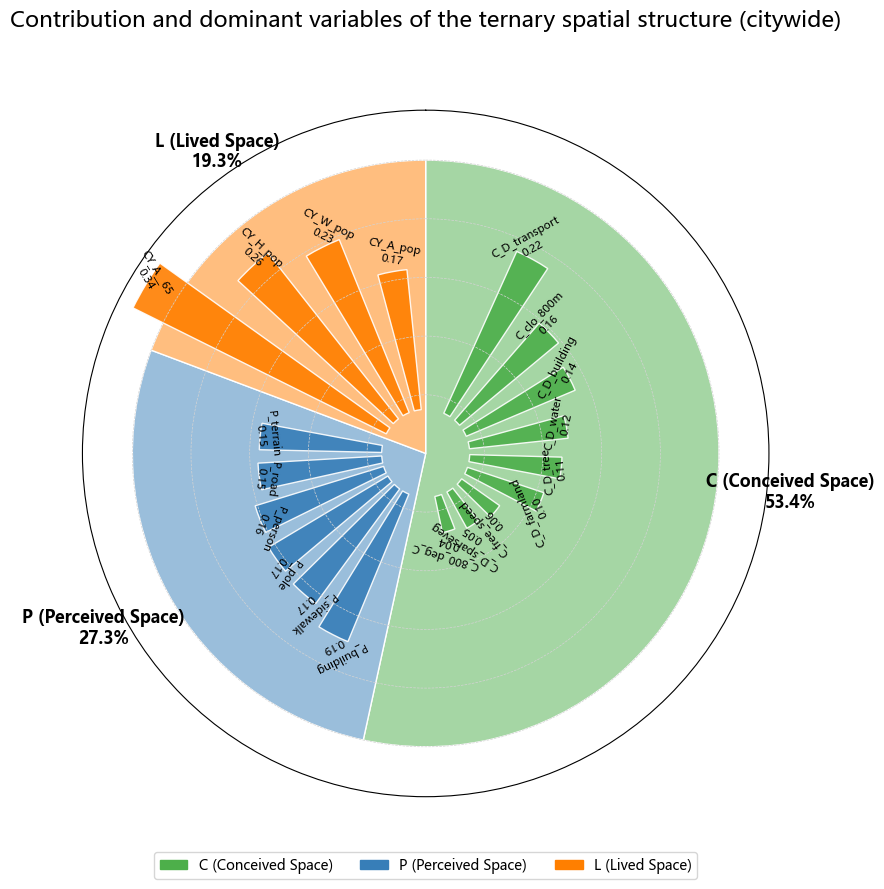

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# === 1. 读取 SHAP 值并计算每组贡献 ===
shap_df = pd.read_csv("保存结果用/cyb制图/shap_all.csv")  # 包含 new_id 列
shap_feature_df = shap_df.drop(columns=["new_id"]).abs()

# === 2. 分组列名 ===
C_cols = [col for col in shap_feature_df.columns if col.startswith("C_")]
P_cols = [col for col in shap_feature_df.columns if col.startswith("P_")]
L_cols = [col for col in shap_feature_df.columns if col.startswith("CY_")]

C_mean = shap_feature_df[C_cols].mean().sort_values(ascending=False)
P_mean = shap_feature_df[P_cols].mean().sort_values(ascending=False)
L_mean = shap_feature_df[L_cols].mean().sort_values(ascending=False)

C_score, P_score, L_score = C_mean.sum(), P_mean.sum(), L_mean.sum()
contribution_total = C_score + P_score + L_score
contribution_ratio = {
    "C (Conceived Space)": C_score / contribution_total,
    "P (Perceived Space)": P_score / contribution_total,
    "L (Lived Space)": L_score / contribution_total
}

# === 3. 构造结构输入 ===
group_data = {
    'C (Conceived Space)': (C_mean.head(9), "#4daf4a"),
    'P (Perceived Space)': (P_mean.head(6), "#377eb8"),
    'L (Lived Space)': (L_mean.head(4), "#ff7f00"),
}
sector_angles = np.array(list(contribution_ratio.values())) * 2 * np.pi
sector_starts = np.concatenate([[0], np.cumsum(sector_angles)[:-1]])

# === 初始化图（添加极坐标线）===
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks([])
ax.set_yticks(np.linspace(0.2, 1.2, 6))  # 添加辅助线
ax.set_yticklabels([])
ax.grid(color='lightgray', linestyle='--', linewidth=0.5)

# === 绘制扇形区域和标签（让标签远离图体） ===
for i, label, angle, start, color in zip(range(3), contribution_ratio.keys(), sector_angles, sector_starts, [v[1] for v in group_data.values()]):
    end = start + angle
    theta = (start + end) / 2
    ax.bar(x=theta, height=1.0, width=angle, color=color + "80", bottom=0, edgecolor='white')

    # 标签稍微远离图形，位置半径从 1.1 调整为 1.25
    ax.text(theta, 1.25, f"{label}\n{contribution_ratio[label]*100:.1f}%", ha='center', va='center', fontsize=12, weight='bold')


# === 外圈柱状图 ===
bar_width = 0.16
radius_base = 0.15
height_scale = 2.8

for (group, (series, color)), start, angle_size in zip(group_data.items(), sector_starts, sector_angles):
    norm_series = series / series.sum()
    num_bars = len(norm_series)
    angles = np.linspace(start + angle_size*0.15, start + angle_size*0.85, num_bars)

    for var, angle, value in zip(norm_series.index, angles, norm_series.values):
        h_abs = value * height_scale
        ax.bar(angle, h_abs, width=bar_width, bottom=radius_base, color=color, edgecolor='white', alpha=0.9)
        ax.text(
            angle,
            radius_base + h_abs + 0.02,
            f"{var}\n{value:.2f}",
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=np.rad2deg(angle),
            rotation_mode='anchor',
        )

# === 图例 ===
patches = [mpatches.Patch(color=color, label=group) for group, (_, color) in group_data.items()]
plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.13), ncol=3, frameon=True)
plt.title("Contribution and dominant variables of the ternary spatial structure (citywide)", fontsize=16, pad=60)
plt.tight_layout()
plt.show()


D:\Anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


福田区模型：R² = 0.7119, RMSE = 0.0441


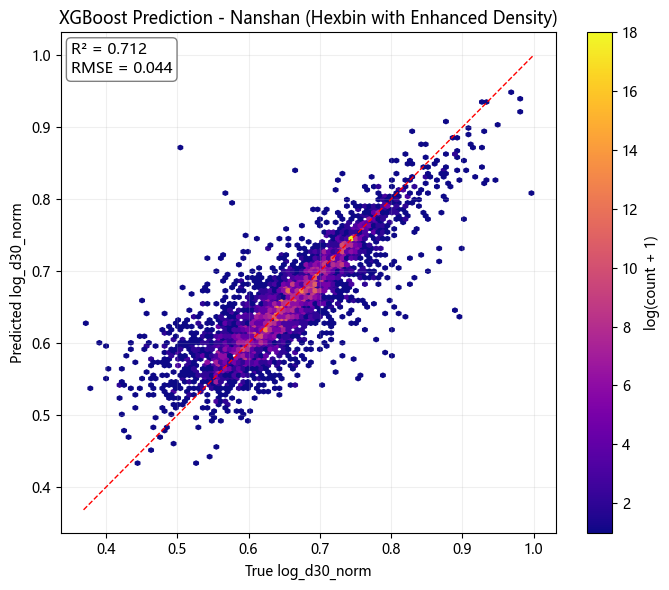

In [61]:
plt.rcParams['font.family'] = 'Microsoft YaHei'   # Windows用户（推荐）

import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# === 1. 读取行政边界 ===
# admin_gdf = gpd.read_file("行政边界/深圳_县级区划.shp")

# === 2. 投影转换匹配 ===
# admin_gdf = admin_gdf.to_crs(gdf_filtered.crs)

# === 3. 选出目标行政区 ===
futian_poly = admin_gdf[admin_gdf['县级'] == '宝安区'].geometry.values[0]

# === 4. 空间子集（福田区）===
gdf_futian = gdf_filtered[gdf_filtered.geometry.within(futian_poly)]

# === 5. 特征准备 ===
X_futian = gdf_futian[feature_cols]
y_futian = gdf_futian['log_d30_norm']

X_train, X_test, y_train, y_test = train_test_split(
    X_futian, y_futian, test_size=0.2, random_state=42
)

# === 6. 模型训练与预测 ===
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=8, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === 7. 性能评估 ===
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"福田区模型：R² = {r2:.4f}, RMSE = {rmse:.4f}")

plt.figure(figsize=(7, 6))

# Hexbin 图（增强密度）
hb = plt.hexbin(
    y_test, y_pred,
    gridsize=100,
    cmap='plasma',
    reduce_C_function=np.log1p,
    mincnt=1
)

# 参考线
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1)

# 左上角标注 R² 和 RMSE
plt.text(
    0.02, 0.98,
    f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=plt.gca().transAxes,
    verticalalignment='top',
    horizontalalignment='left',
    fontsize=11,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# 标注
plt.xlabel("True log_d30_norm")
plt.ylabel("Predicted log_d30_norm")
plt.title("XGBoost Prediction - Nanshan (Hexbin with Enhanced Density)")

# 色条和透明网格
plt.colorbar(hb, label='log(count + 1)')
plt.grid(alpha=0.2)  # 更淡的网格线
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_31828\3249288116.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


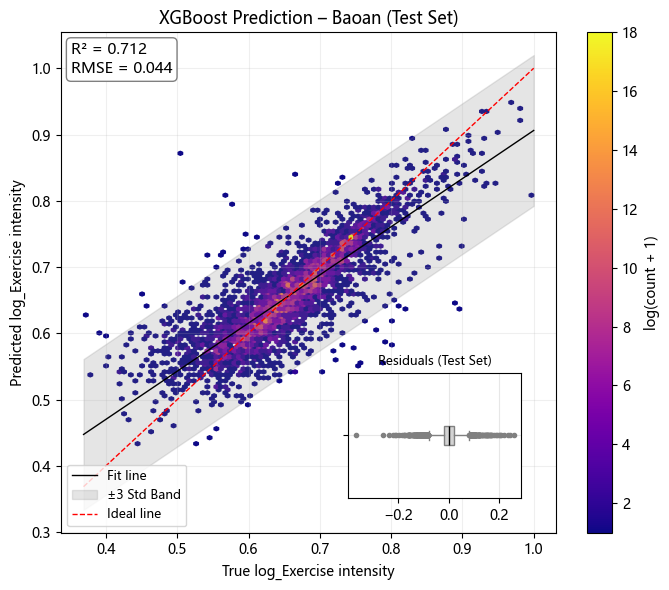

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# === 主图：测试集预测 Hexbin ===
fig, ax = plt.subplots(figsize=(7, 6))

hb = ax.hexbin(
    y_test, y_pred,
    gridsize=100,
    cmap='plasma',
    reduce_C_function=np.log1p,
    mincnt=1
)

# === 拟合线 + 置信区间 ===
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
x_line = np.linspace(y_test.min(), y_test.max(), 200)
y_fit = p(x_line)
fit_residuals = y_pred - p(y_test)
std = np.std(fit_residuals)
y_upper = y_fit + 3 * std
y_lower = y_fit - 3 * std

ax.plot(x_line, y_fit, "k-", lw=1, label="Fit line")
ax.fill_between(x_line, y_lower, y_upper, color='gray', alpha=0.2, label="±3 Std Band")
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1, label="Ideal line")

# === R² 和 RMSE 标注 ===
ax.text(
    0.02, 0.98,
    f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=ax.transAxes,
    verticalalignment='top',
    horizontalalignment='left',
    fontsize=11,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

# === 主图设置 ===
ax.set_xlabel("True log_Exercise intensity")
ax.set_ylabel("Predicted log_Exercise intensity")
ax.set_title("XGBoost Prediction – Baoan (Test Set)")
ax.grid(alpha=0.2)
plt.colorbar(hb, ax=ax, label='log(count + 1)')

# === 子图：残差箱型图，位置上移 ===
residuals = y_test - y_pred
inset_ax = inset_axes(ax, width="35%", height="25%", loc='lower right', borderpad=2.5)

inset_ax.boxplot(residuals, vert=False, patch_artist=True,
                 boxprops=dict(facecolor='lightgray', color='gray'),
                 medianprops=dict(color='black'),
                 whiskerprops=dict(color='gray'),
                 capprops=dict(color='gray'),
                 flierprops=dict(marker='o', markersize=3, markerfacecolor='gray', markeredgecolor='gray'))

inset_ax.set_title("Residuals (Test Set)", fontsize=9)
inset_ax.tick_params(axis='y', labelleft=False)
inset_ax.grid(alpha=0.3)

# === 图例移动到左下角，避免遮挡文字 ===
ax.legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.savefig("保存结果用/cyb制图/宝安散点.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()


In [63]:
import shap
import pandas as pd

# 构建 explainer
explainer = shap.Explainer(model)

# 计算 SHAP
print("📊 正在计算宝安 SHAP 值...")
shap_values = explainer(X_futian)

# 保存 SHAP
shap_df_futian = pd.DataFrame(shap_values.values, columns=X_futian.columns)
shap_df_futian['new_id'] = gdf_futian['new_id'].values
shap_df_futian.to_csv("保存结果用/cyb制图/宝安_shap_all.csv", index=False)

📊 正在计算宝安 SHAP 值...


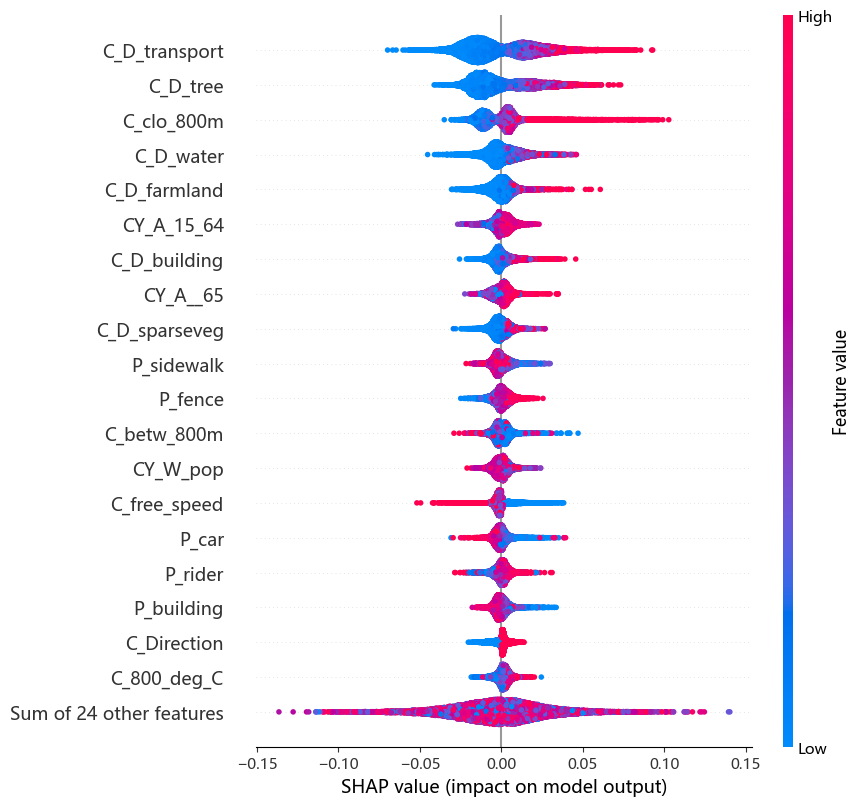

<Figure size 640x480 with 0 Axes>

In [64]:
# 构造 SHAP 值对象（仅用于绘图）
shap_values_array = shap_df_futian.drop(columns='new_id').values
shap_values_futian = shap.Explanation(values=shap_values_array, data=X_futian.values, feature_names=X_futian.columns)

# 全局 Summary plot
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values_futian, show=True, max_display=20)
plt.tight_layout()

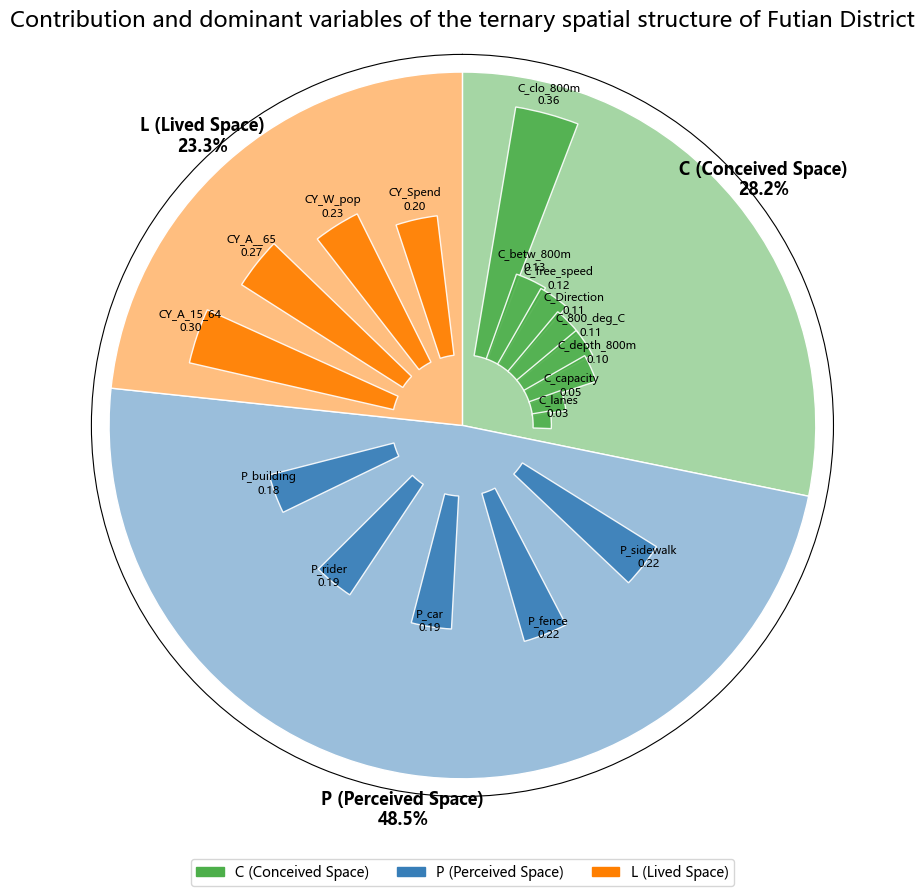

In [65]:
# # 分组前缀
# C_cols = [col for col in X_futian.columns if col.startswith("C_")]
# P_cols = [col for col in X_futian.columns if col.startswith("P_")]
# L_cols = [col for col in X_futian.columns if col.startswith("L_")]
# 分组前缀
C_cols_all = [col for col in X_futian.columns if col.startswith("C_")]
C_cols = [col for col in C_cols_all if not col.startswith("C_D_")]  # ❗排除 C_D_
P_cols = [col for col in X_futian.columns if col.startswith("P_")]
L_cols = [col for col in X_futian.columns if col.startswith("CY_")]

# 平均绝对 SHAP 值
shap_df_futian = pd.read_csv("保存结果用/cyb制图/宝安_shap_all.csv")
shap_abs = shap_df_futian.drop(columns=['new_id']).abs()

C_mean = shap_abs[C_cols].mean().sort_values(ascending=False)
P_mean = shap_abs[P_cols].mean().sort_values(ascending=False)
L_mean = shap_abs[L_cols].mean().sort_values(ascending=False)

# 分组总贡献
C_score = C_mean.sum()
P_score = P_mean.sum()
L_score = L_mean.sum()

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# === 设置 ===
group_data = {
    'C (Conceived Space)': (C_mean.head(8), "#4daf4a"),
    'P (Perceived Space)': (P_mean.head(5), "#377eb8"),
    'L (Lived Space)': (L_mean.head(4), "#ff7f00"),
}

contribution_total = C_score + P_score + L_score
contribution_ratio = {
    "C (Conceived Space)": C_score / contribution_total,
    "P (Perceived Space)": P_score / contribution_total,
    "L (Lived Space)": L_score / contribution_total
}
sector_angles = np.array(list(contribution_ratio.values())) * 2 * np.pi
sector_starts = np.concatenate([[0], np.cumsum(sector_angles)[:-1]])

# === 初始化图 ===
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks([])
ax.set_yticks([])

# === 绘制扇形区域和标签 ===
for i, (label, angle, start, color) in enumerate(zip(contribution_ratio.keys(), sector_angles, sector_starts, group_data.values())):
    end = start + angle
    theta = (start + end) / 2
    ax.bar(x=theta, height=1.0, width=angle, color=color[1] + "80", bottom=0, edgecolor='white')
    ax.text(theta, 1.1, f"{label}\n{contribution_ratio[label]*100:.1f}%", ha='center', va='center', fontsize=12, weight='bold')

# === 绘制每个组的柱状图 ===
bar_width = 0.2  # 固定每个柱的宽度
radius_base = 0.2
height_scale = 2

for i, ((group, (series, color)), start, angle_size) in enumerate(zip(group_data.items(), sector_starts, sector_angles)):
    top_k = series / series.sum()  # 按组内比例归一化
    num_bars = len(top_k)
    angles = np.linspace(start + angle_size*0.15, start + angle_size*0.85, num_bars)

    for var, angle, h_rel in zip(top_k.index, angles, top_k.values):
        h_abs = h_rel * height_scale
        ax.bar(angle, h_abs, width=bar_width, bottom=radius_base, color=color, edgecolor='white', alpha=0.9)
        ax.text(angle, radius_base + h_abs + 0.02, f"{var}\n{h_rel:.2f}", ha='center', va='bottom', fontsize=8)

# === 图例 ===
patches = [mpatches.Patch(color=color, label=group) for group, (_, color) in group_data.items()]
plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.13), ncol=3, frameon=True)
plt.title("Contribution and dominant variables of the ternary spatial structure of Futian District", fontsize=16, pad=20)
plt.tight_layout()
plt.show()


In [22]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import box

# === 路径定义 ===
gdf_path = "cyb_shenzhen.geojson"
admin_path = "行政边界/深圳_县级区划.shp"
shap_path = "保存结果用/cyb制图/futian_shap_all.csv"

# === 1. 读取数据并统一 CRS ===
input_gdf = gpd.read_file(gdf_path)
admin_gdf = gpd.read_file(admin_path).to_crs(input_gdf.crs)
shap_df = pd.read_csv(shap_path)
input_gdf = input_gdf.merge(shap_df, on='new_id')  # 合并 SHAP 值

# === 2. 提取福田区 + 1000m 缓冲区 ===
futian_poly = admin_gdf[admin_gdf['县级'] == '福田区'].geometry.values[0]
futian_buffer = gpd.GeoDataFrame(geometry=[futian_poly.buffer(1000)], crs=input_gdf.crs)

# === 3. 裁剪数据集为分析区域（道路 + SHAP）===
gdf_clip = input_gdf[input_gdf.geometry.centroid.within(futian_buffer.geometry.values[0])]

In [25]:
shap_df

,C_Direction,C_lanes,C_free_speed,C_capacity,C_link_type,C_D_transport,C_D_tree,C_D_grass,C_D_farmland,C_D_building,...,P_bicycle,CY_W_pop,CY_A_pop,CY_H_pop,CY_Spend,CY_A_0_14,CY_A_15_64,CY_A__65,CY_A_un,new_id
0,0.006583,-0.003855,-0.000060,-0.008354,0.000259,-0.012437,-0.005208,0.000188,-0.019257,-0.021510,...,-0.005229,-0.002720,0.000014,0.002881,0.005146,0.004979,-0.000167,-0.006388,0.000211,47
1,0.002251,-0.002496,-0.003600,-0.010479,0.000244,-0.008651,-0.006576,-0.000292,0.000279,-0.023412,...,0.000818,-0.001592,-0.001261,0.002930,-0.004690,0.000361,-0.000515,-0.000337,-0.004644,48
2,0.002349,0.000987,-0.004348,-0.000062,0.000544,-0.011683,-0.003355,-0.000077,-0.003730,-0.022965,...,-0.000558,-0.002455,-0.004309,-0.000178,-0.007254,0.001849,-0.000479,-0.001574,-0.003871,49
3,0.005591,0.000896,-0.001235,-0.000898,0.001115,-0.013206,0.001871,-0.000068,-0.011915,-0.018925,...,-0.000150,-0.001472,-0.001751,0.001916,-0.007122,0.001399,0.000314,0.001326,-0.001634,50
4,0.003796,-0.006055,-0.003293,0.001198,-0.001723,-0.010434,-0.005225,-0.000079,-0.009216,-0.021363,...,0.000458,-0.018975,0.001727,-0.001288,0.000088,-0.000892,0.003074,-0.002425,-0.006759,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12921,-0.002375,0.000720,-0.014855,-0.000752,-0.002015,-0.015542,-0.001352,-0.000042,0.002701,-0.027842,...,-0.006445,-0.004404,-0.001619,-0.013865,-0.003977,-0.000840,-0.000305,-0.006112,0.001787,145865
12922,0.005094,0.000605,-0.008844,-0.000416,-0.001980,-0.019209,-0.001449,-0.000053,0.012428,-0.024221,...,-0.001262,-0.000556,-0.000615,-0.006492,0.000891,-0.000015,-0.000313,-0.006621,0.004767,145866
12923,0.004594,-0.000089,0.011492,0.000283,0.002986,-0.000083,0.002208,0.000025,-0.016808,-0.010110,...,0.001000,-0.007543,0.006042,0.005558,0.002647,-0.002833,0.000423,-0.001000,-0.003350,146294
12924,0.001442,0.001566,0.018018,-0.002599,0.002227,0.002037,0.001724,-0.000081,-0.017602,-0.026969,...,0.000446,0.013846,-0.000310,-0.006786,-0.004782,-0.000205,0.001592,-0.002496,0.006699,146295


🔍 C_Direction: +20% → 平均提升 0.00%
🔍 C_lanes: +20% → 平均提升 0.06%
🔍 C_free_speed: +20% → 平均提升 1.43%
🔍 C_capacity: +20% → 平均提升 -0.02%
🔍 C_link_type: +20% → 平均提升 0.02%
🔍 C_D_transport: +20% → 平均提升 -1.71%
🔍 C_D_tree: +20% → 平均提升 0.31%
🔍 C_D_grass: +20% → 平均提升 0.00%
🔍 C_D_farmland: +20% → 平均提升 -1.98%
🔍 C_D_building: +20% → 平均提升 -1.61%
🔍 C_D_sparseveg: +20% → 平均提升 -0.23%
🔍 C_D_water: +20% → 平均提升 -0.56%
🔍 C_800_deg_C: +20% → 平均提升 0.28%
🔍 C_betw_800m: +20% → 平均提升 -0.10%
🔍 C_clo_800m: +20% → 平均提升 -0.86%
🔍 C_depth_800m: +20% → 平均提升 0.59%
🔍 P_road: +20% → 平均提升 -0.31%
🔍 P_sidewalk: +20% → 平均提升 -0.01%
🔍 P_building: +20% → 平均提升 2.15%
🔍 P_wall: +20% → 平均提升 0.26%
🔍 P_fence: +20% → 平均提升 -1.03%
🔍 P_pole: +20% → 平均提升 -0.62%
🔍 P_traffic li: +20% → 平均提升 -0.14%
🔍 P_traffic si: +20% → 平均提升 0.28%
🔍 P_vegetation: +20% → 平均提升 -0.31%
🔍 P_terrain: +20% → 平均提升 -0.09%
🔍 P_sky: +20% → 平均提升 -1.26%
🔍 P_person: +20% → 平均提升 -0.89%
🔍 P_rider: +20% → 平均提升 -0.31%
🔍 P_car: +20% → 平均提升 -0.37%
🔍 P_truck: +20% → 平均提升 -0.20%
🔍 P_b

C:\Users\admin\AppData\Local\Temp\ipykernel_31828\2096671899.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_neg = plt.cm.get_cmap("Greys_r", 128)  # 从黑到灰
C:\Users\admin\AppData\Local\Temp\ipykernel_31828\2096671899.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_pos = plt.cm.get_cmap("Reds", 128)     # 从灰到红


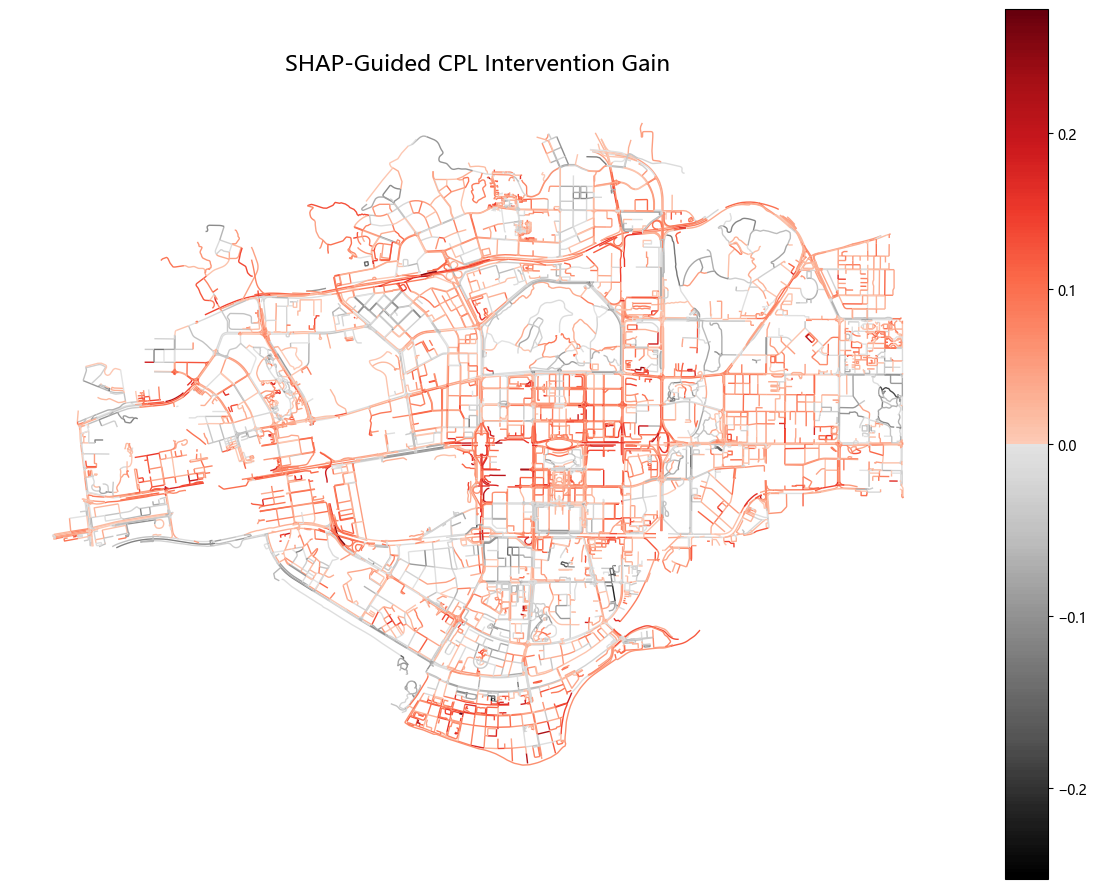

In [26]:
def simulate_joint_variable_with_output(
    X_base, model, gdf_base, group_prefixes=["P_"], step=0.2, cap=1.0, top_k=8, label="gain_P"
):
    # === Step 1: 获取变量 ===
    candidate_vars = [
        col for col in X_base.columns if any(col.startswith(p) for p in group_prefixes)
    ]
    y_base = model.predict(X_base)
    base_mean = y_base.mean()

    # === Step 2: 单变量干预模拟 ===
    improvement_dict = {}
    for var in candidate_vars:
        X_temp = X_base.copy()
        X_temp[var] = np.minimum(X_temp[var] * (1 + step), cap)
        y_new = model.predict(X_temp)
        gain = (y_new.mean() - base_mean) / base_mean * 100
        improvement_dict[var] = gain
        print(f"🔍 {var}: +{int(step*100)}% → 平均提升 {gain:.2f}%")

    # === Step 3: 联合干预 top-K 变量 ===
    top_k_vars = sorted(improvement_dict, key=improvement_dict.get, reverse=True)[:top_k]
    print(f"\n✅ Top-{top_k} 联合干预变量 (来自 {'/'.join(group_prefixes)}): {top_k_vars}")

    X_joint = X_base.copy()
    for var in top_k_vars:
        X_joint[var] = np.minimum(X_joint[var] * (1 + step), cap)

    y_joint = model.predict(X_joint)
    residual = y_joint - y_base
    gain_pct = (y_joint.mean() - y_base.mean()) / y_base.mean() * 100

    print(f"📈 干预后预测均值提升：{gain_pct:.2f}%")

    # === Step 4: 保存结果到 gdf
    gdf_result = gdf_base.copy()
    gdf_result[label] = residual

    import matplotlib.pyplot as plt
    
    # fig, ax = plt.subplots(figsize=(12, 9))
    
    # # 正确使用 gdf_result 而不是 gdf_futian
    # gdf_result.plot(
    #     column=label,               # 自动使用 gain_P
    #     cmap='coolwarm',
    #     legend=True,
    #     linewidth=1.2,
    #     ax=ax,
    #     missing_kwds={"color": "lightgrey", "label": "No Data"}
    # )
    
    # ax.set_title("SHAP-Guided P空间干预后道路运动提升", fontsize=16, pad=15)
    # ax.set_axis_off()
    # plt.tight_layout()
    # plt.show()
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from matplotlib.colors import TwoSlopeNorm
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # 设置最大最小值，用于渐变色标准化
    vmin = gdf_result[label].min()
    vmax = gdf_result[label].max()
    
    # 构建渐变色带：
    # 前半：黑色 → 灰色（负值）
    # 后半：灰色 → 红色（正值）
    cmap_neg = plt.cm.get_cmap("Greys_r", 128)  # 从黑到灰
    cmap_pos = plt.cm.get_cmap("Reds", 128)     # 从灰到红
    
    # 拼接为一条连续 colormap
    new_colors = np.vstack((
        cmap_neg(np.linspace(0.0, 0.8, 128)),   # 控制灰色程度
        cmap_pos(np.linspace(0.2, 1.0, 128))
    ))
    custom_cmap = mcolors.ListedColormap(new_colors, name='black_grey_red')
    
    # 设置双边标准化：以0为中点
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    
    # 绘图
    gdf_result.plot(
        column=label,
        cmap=custom_cmap,
        norm=norm,
        legend=True,
        linewidth=1.0,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No Data"}
    )
    
    ax.set_title("SHAP-Guided CPL Intervention Gain", fontsize=16, pad=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()




    return gdf_result, top_k_vars, gain_pct
gdf_futian, top_vars_P, avg_gain = simulate_joint_variable_with_output(
    X_base=X_futian,
    model=model,
    gdf_base=gdf_futian,
    group_prefixes=["P_","C_","CY_"],
    step=0.2,
    cap=1.0,
    top_k=20,
    label="gain_P"
)


In [27]:
gdf_futian["y_base"] = model.predict(X_futian)
gdf_futian

,C_Direction,C_length,C_lanes,C_free_speed,C_capacity,C_link_type,L_poi_entropy300,L_poi_entropy200,L_poi_entropy100,L_urban_mean,...,CY_A_pop,CY_H_pop,CY_Spend,CY_A_0_14,CY_A_15_64,CY_A__65,CY_A_un,geometry,gain_P,y_base
46,1.0,374.26703,3.0,60.0,2200.0,2.0,2.242578,2.116773,1.463384,0.535815,...,0.592541,0.637326,0.910905,1.595005,0.530912,0.689574,0.577691,"LINESTRING (198420.176 2495314.053, 198420.006...",-0.023851,0.602604
47,1.0,236.77437,3.0,60.0,2200.0,2.0,2.176039,1.885020,1.332179,0.421429,...,0.292332,0.190768,-0.450358,1.273984,0.097781,0.526542,0.377780,"LINESTRING (198420.006 2494939.786, 198417.779...",0.123846,0.577320
48,1.0,165.75737,2.0,40.0,1800.0,3.0,1.818063,1.921262,1.585471,0.537368,...,0.292332,0.190768,-0.450358,1.273984,0.097781,0.526542,0.377780,"LINESTRING (198350.943 2494668.932, 198185.19 ...",0.103948,0.551425
49,1.0,124.52833,2.0,40.0,1800.0,3.0,1.843002,1.692490,1.864057,0.533333,...,0.292332,0.190768,-0.450358,1.273984,0.097781,0.526542,0.377780,"LINESTRING (198185.19 2494670.158, 198128.848 ...",-0.015613,0.618079
62,1.0,84.03621,3.0,80.0,1800.0,3.0,1.766298,1.856658,0.450561,0.553846,...,1.898182,0.016795,0.645490,0.697579,0.927621,0.296532,0.995988,"LINESTRING (196635.225 2495892.906, 196628.443...",0.156846,0.502376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115038,0.0,213.78111,1.0,30.0,800.0,8.0,1.270542,1.142884,1.230932,0.384694,...,-0.213669,-0.137118,0.507664,-0.880696,0.244112,-0.087843,0.109842,"LINESTRING (196078.953 2491941.631, 196196.519...",0.171509,0.502083
115039,0.0,213.92988,1.0,30.0,800.0,8.0,1.333812,1.130705,1.282231,0.384694,...,-0.213669,-0.137118,0.507664,-0.880696,0.244112,-0.087843,0.109842,"LINESTRING (196199.641 2492033.284, 196188.14 ...",0.029613,0.633576
115341,1.0,293.43816,1.0,5.0,800.0,9.0,1.746436,1.668174,1.039721,0.000000,...,0.925714,0.229957,0.303832,0.697579,0.537878,0.412550,0.423198,"LINESTRING (198973.357 2496816.624, 198937.183...",0.007299,0.683830
115342,1.0,198.87457,1.0,5.0,800.0,10.0,2.287836,2.261159,2.011692,0.557290,...,-6.290429,-6.102804,-5.724642,-0.880696,-6.211407,-4.138483,-6.206844,"LINESTRING (198112.176 2493122.87, 198111.017 ...",0.034114,0.683095


In [29]:
import geopandas as gpd

# 读取错配区域（grid LISA 结果中筛选后的部分）
grid_mismatch = gpd.read_file("保存结果用/grid_futian_valid_mismatch_selected.geojson")

# 与 gdf_result 保持一致的 CRS
grid_mismatch = grid_mismatch.to_crs(gdf_futian.crs)

# 仅保留与错配区域相交的道路（注意使用 geometry 而非 centroid）
gdf_futian_mismatch = gdf_futian[gdf_futian.geometry.intersects(grid_mismatch.unary_union)].copy()

print(f"✅ 选出 {len(gdf_futian_mismatch)} 条与错配区域相交的道路")


C:\Users\admin\AppData\Local\Temp\ipykernel_31828\3006768898.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_futian_mismatch = gdf_futian[gdf_futian.geometry.intersects(grid_mismatch.unary_union)].copy()


✅ 选出 4734 条与错配区域相交的道路


In [30]:
# 获取干预变量 residual（提升值）与 y_base（原始预测）
gdf_futian_mismatch["y_after"] = gdf_futian_mismatch["y_base"] + gdf_futian_mismatch["gain_P"]
gdf_futian_mismatch["gain_pct"] = (gdf_futian_mismatch["y_after"] - gdf_futian_mismatch["y_base"]) / gdf_futian_mismatch["y_base"] * 100

print("📈 平均提升：", gdf_futian_mismatch["gain_pct"].mean(), "%")


📈 平均提升： 5.6990314 %


🔍 C_Direction: +20% → 平均提升 0.00%
🔍 C_lanes: +20% → 平均提升 -0.03%
🔍 C_free_speed: +20% → 平均提升 3.10%
🔍 C_capacity: +20% → 平均提升 -0.14%
🔍 C_link_type: +20% → 平均提升 0.07%
🔍 C_D_transport: +20% → 平均提升 -2.64%
🔍 C_D_tree: +20% → 平均提升 -0.17%
🔍 C_D_grass: +20% → 平均提升 -0.00%
🔍 C_D_farmland: +20% → 平均提升 -0.90%
🔍 C_D_building: +20% → 平均提升 -0.05%
🔍 C_D_sparseveg: +20% → 平均提升 -0.09%
🔍 C_D_water: +20% → 平均提升 -0.14%
🔍 C_800_deg_C: +20% → 平均提升 0.19%
🔍 C_betw_800m: +20% → 平均提升 0.18%
🔍 C_clo_800m: +20% → 平均提升 -0.91%
🔍 C_depth_800m: +20% → 平均提升 1.35%
🔍 P_road: +20% → 平均提升 0.99%
🔍 P_sidewalk: +20% → 平均提升 -0.14%
🔍 P_building: +20% → 平均提升 1.35%
🔍 P_wall: +20% → 平均提升 -1.40%
🔍 P_fence: +20% → 平均提升 -1.02%
🔍 P_pole: +20% → 平均提升 -0.62%
🔍 P_traffic li: +20% → 平均提升 0.59%
🔍 P_traffic si: +20% → 平均提升 -2.47%
🔍 P_vegetation: +20% → 平均提升 -2.15%
🔍 P_terrain: +20% → 平均提升 1.96%
🔍 P_sky: +20% → 平均提升 -1.01%
🔍 P_person: +20% → 平均提升 -1.12%
🔍 P_rider: +20% → 平均提升 -0.24%
🔍 P_car: +20% → 平均提升 1.57%
🔍 P_truck: +20% → 平均提升 0.94%
🔍 P_bu

C:\Users\admin\AppData\Local\Temp\ipykernel_31828\2096671899.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_neg = plt.cm.get_cmap("Greys_r", 128)  # 从黑到灰
C:\Users\admin\AppData\Local\Temp\ipykernel_31828\2096671899.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_pos = plt.cm.get_cmap("Reds", 128)     # 从灰到红


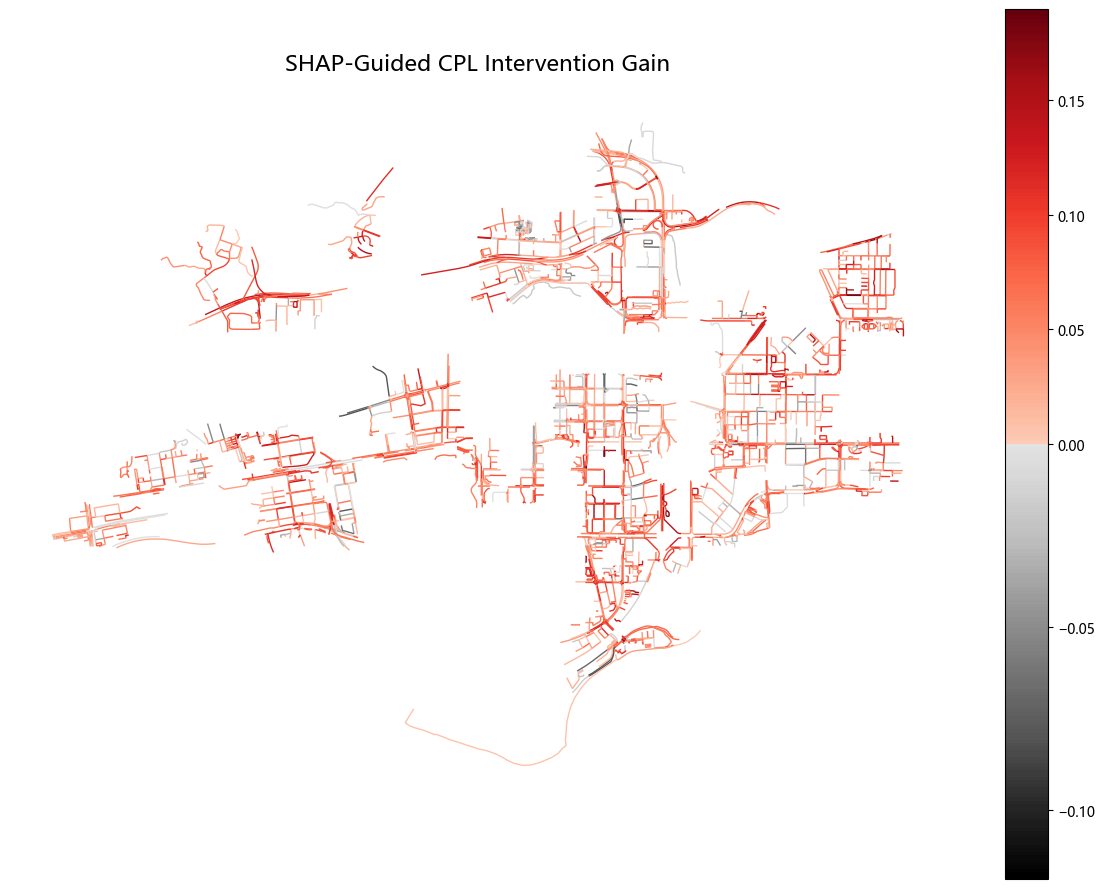

In [66]:

# 确保匹配的特征字段
X_futian_mismatch = gdf_futian_mismatch[X_futian.columns]
gdf_futian_mismatch_updated, top_vars_selected, avg_gain_pct = simulate_joint_variable_with_output(
    X_base=X_futian_mismatch,
    model=model,
    gdf_base=gdf_futian_mismatch,
    group_prefixes=[ "C_","P_","CY_"],
    step=0.2,
    cap=1.0,
    top_k=10,
    label="gain_CPL"
)
